In [1]:
import os
import glob
import shutil

import pydicom
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.data_utils import Sequence
from tensorflow.keras.utils import multi_gpu_model
import mlflow.tensorflow as mlflow_tensorflow

from src.mask_functions import rle2mask
from src.train_utils import *
from src.unet import *
from src.fcn import *

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["NO_PROXY"] = "localhost, 0.0.0.0, 127.0.0.1"
os.environ["no_proxy"] = "localhost, 0.0.0.0, 127.0.0.1"
get_available_gpus()

W0917 19:48:56.241817 139824952502016 deprecation_wrapper.py:119] From /home/eoconnell/pneumothorax_segmentation/src/resnet_helpers.py:1: The name tf.keras.layers.CuDNNGRU is deprecated. Please use tf.compat.v1.keras.layers.CuDNNGRU instead.

W0917 19:48:56.243744 139824952502016 deprecation_wrapper.py:119] From /home/eoconnell/pneumothorax_segmentation/src/resnet_helpers.py:1: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



['/device:GPU:0']

In [2]:
train_annotations = "/home/eoconnell/datasets/kaggle/pneumothorax_segmentation/train-rle.csv"
train_data_loc = "/home/eoconnell/datasets/kaggle/pneumothorax_segmentation/dicom-images-train/"

img_width = 224
img_height = 224
img_channel = 1
batch_size = 32

file_locs = glob.glob(train_data_loc + "/*/*/*.dcm")
df = pd.read_csv(train_annotations, skipinitialspace=True)

train_files, test_files = train_test_split(
    file_locs, test_size=0.2, random_state=42)

train_data_gen = data_gen(df, train_files,
                          img_width=img_width,
                          img_height=img_height,
                          img_channel=img_channel, 
                          batch_size=batch_size)
test_data_gen = data_gen(df, test_files,
                         img_width=img_width,
                         img_height=img_height,
                         img_channel=img_channel)

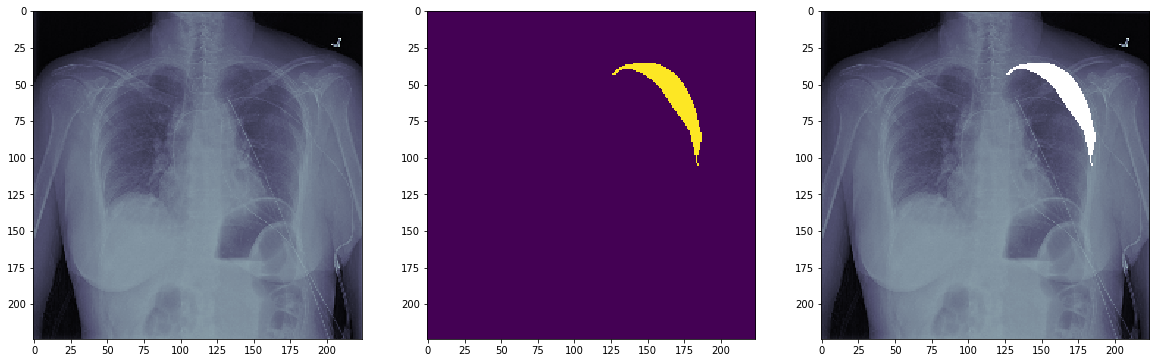

In [ ]:
i = 0
for img, mask in tqdm(train_data_gen()):
    img = np.squeeze(img[0])
    mask = np.squeeze(mask[0])
    
    if np.sum(mask) < 1:
        continue
    
    fig, ax = plt.subplots(1, 3)
    img_w_mask = img.copy()
    img_w_mask[mask.astype(bool)] = 255
    
    fig.set_figwidth(20)
    fig.set_figheight(10)
    
    ax[0].imshow(img, cmap=plt.cm.bone)
    ax[1].imshow(mask)
    ax[2].imshow(img_w_mask, cmap=plt.cm.bone)
    break

In [ ]:
nb_epoch = 100
lr_base = 0.001
steps_per_epoch=len(train_files)
validation_steps=len(test_files)
multi_gpu = False

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

mlflow.set_tracking_uri("http://0.0.0.0:6600")
mlflow.set_experiment("pneumothorax_segmentation")

with mlflow.start_run():
    
    # Log hyperparameters
    mlflow_tensorflow.autolog(every_n_iter=1)
    mlflow.log_param("batch size", batch_size)
    mlflow.log_param("epochs", nb_epoch)
    mlflow.log_param("learning rate", lr_base)


    model = unet(input_size=(img_width, img_height, img_channel))
    #model = FCN_Resnet50_32s((img_width, img_height, img_channel))
    model.summary()

    if multi_gpu:
        model = multi_gpu_model(model, gpus=4)

    adam_optimizer=tf.train.AdamOptimizer()#learning_rate=lr_base)

    model.compile(loss="binary_crossentropy",
                  optimizer=tf.train.AdamOptimizer(learning_rate=lr_base),
                  metrics=['binary_crossentropy', dice_coef])

    log_dir = "/home/eoconnell/pneumothorax_segmentation/model_dir/"
    if os.path.isdir(log_dir):
        print("is dir")
        shutil.rmtree(log_dir)


    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=log_dir)


    history = model.fit_generator(train_data_gen,
                        validation_data=test_data_gen,
                        steps_per_epoch=steps_per_epoch//batch_size,
                        validation_steps=validation_steps//batch_size,
                        epochs=nb_epoch,
                        callbacks=[tensorboard_callback],
                        workers=10,
                        use_multiprocessing=True)
    log_history_obj(history)

W0917 19:48:58.704873 139824952502016 deprecation.py:506] From /home/eoconnell/.local/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0917 19:48:58.764174 139824952502016 deprecation.py:323] From /home/eoconnell/.local/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

Epoch 1/100
266/266 [==============================] - 226s 851ms/step - loss: 0.1800 - binary_crossentropy: 0.1800 - dice_coef: 0.0045 - val_loss: 0.0177 - val_binary_crossentropy: 0.0177 - val_dice_coef: 0.0078
Epoch 2/100
266/266 [==============================] - 223s 837ms/step - loss: 0.0155 - binary_crossentropy: 0.0155 - dice_coef: 0.0080 - val_loss: 0.0192 - val_binary_crossentropy: 0.0192 - val_dice_coef: 0.0033
Epoch 3/100
266/266 [==============================] - 224s 841ms/step - loss: 0.0162 - binary_crossentropy: 0.0162 - dice_coef: 0.0053 - val_loss: 0.0177 - val_binary_crossentropy: 0.0177 - val_dice_coef: 0.0089
Epoch 4/100
266/266 [==============================] - 224s 843ms/step - loss: 0.0153 - binary_crossentropy: 0.0153 - dice_coef: 0.0082 - val_loss: 0.0168 - val_binary_crossentropy: 0.0168 - val_dice_coef: 0.0100
Epoch 5/100
266/266 [==============================] - 224s 842ms/step - loss: 0.0152 - binary_crossentropy: 0.0152 - dice_coef: 0.0098 - val_loss: 